<div align="center">

# Оценка важности признаков с помощью случайных лесов

</div>

---

Используя метод **случайный лес (Random Forest)**, мы можем измерить значимость признаков, как усредненное уменьшение примеси, вычисленное по всем деревьям решений в лесу, не делая никаких предположений о том, являются ли наши данные линейно разделимыми или нет.

Реализация **случайного леса** в **scikit-learn** уже собирает для нас значения важности функций, чтобы мы могли получить к ним доступ через атрибут `feature_importances_`.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Загрузка датасета Wine из репозитория UCI в DataFrame без заголовков
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/'
                      'wine/wine.data', header=None)

# Назначение имен столбцам для лучшей читаемости и удобства
df_wine.columns = ['Class label',        # Класс вина (1, 2 или 3)
                   'Alcohol',            # Содержание алкоголя
                   'Malic acid',         # Яблочная кислота
                   'Ash',                # Зольность
                   'Alcalinity of ash',  # Щелочность золы
                   'Magnesium',          # Магний
                   'Total phenols',      # Общее количество фенолов
                   'Flavanoids',         # Флавоноиды
                   'Nonflavanoid phenols',       # Нефлавоноидные фенолы
                   'Proanthocyanins',             # Проантоцианы
                   'Color intensity',             # Интенсивность цвета
                   'Hue',                         # Оттенок
                   'OD280/OD315 of diluted wines',# Показатель OD280/OD315
                   'Proline']   


In [17]:
#Разделение данных на обучающие и тестовые выборки
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size = 0.3,
                     random_state = 0,
                     stratify = y)

In [18]:
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators = 500,
                                random_state = 1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))    

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


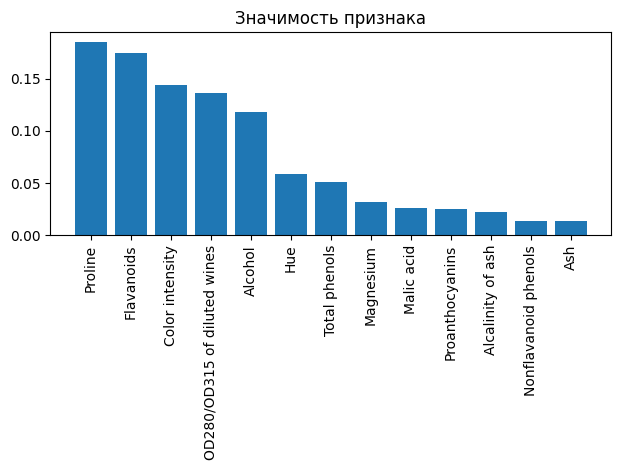

In [19]:
plt.title('Значимость признака')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align = 'center')
plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation = 90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Как видно на графике `Значимость признаков`, который ранжирует признаки по их относительной значимости - значимость признаков нормализована, так что их сумма равна $1.0$.

Можно заключить, что уровни `пролина (Proline)` и `флавоноидов (Flavanoids)`, `интенсивность цвета (color intensity)`, `фактор OD280/OD315 разбавленных вин (OD280/0D315 of diluted wines)` и `концентрация алкоголя (Alcohol)` в вине являются наиболее отличительными признаками в наборе данных, основанном на среднем снижении примесейв 500 деревьях решений. Интересно, что два признака с наивысшим рейтингом на графике также входят в подмножество из трех признаков, найденных алгоритмом SBS
(концентрация алкоголя и фактор OD280/OD315 разбавленных вин).


### Важные замечания по интерпретируемости случайного леса:

* При наличии **сильно коррелированных признаков** один из них может получить **завышенную важность**, а информация об остальных будет **неполной**.
* Это **не влияет на прогностическую точность**, но **может исказить интерпретацию важности признаков**.

---

### Инструмент для отбора признаков:

* В **scikit-learn** реализован объект `SelectFromModel`, который позволяет **автоматически отбирать признаки** на основе **заданного порога важности**.
* Это полезно для использования `RandomForestClassifier` как **селектора признаков** в составе **Pipeline**.

---

In [20]:
sfm = SelectFromModel(forest, threshold = 0.1, 
                      prefit = True)
X_selected = sfm.transform(X_train)
print('Кол-во признаков, соответсвующих пороговому',
      'критерию: ', X_selected.shape[1])

# Вывод этих признаков
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))    

Кол-во признаков, соответсвующих пороговому критерию:  5
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
